In [1]:
import numpy as np
import os
import trimesh
import glob
import random
import seaborn as sns
import json
from pathlib import Path
import io
from PIL import Image
# Best model avg angle 8.11°

def get_plane(fname):
    crimefile = open(r"C:\temp\planes\{}.txt".format(fname), 'r')
    line = crimefile.readlines()[0].replace('\n', '')
    data = np.array(line.split(',')).astype(float).reshape(2, 3)
    normals = data[0, :]
    origin = data[1, :]
    return origin, normals

def show_mesh_and_pale(fname):
    mesh_o = trimesh.load_mesh(r"C:\temp\Segmented\{}.ply".format(fname))
    origin, normals = get_plane(fname)
    scene = trimesh.Scene([mesh_o, trimesh.path.creation.grid(side=20,
                                                  plane_origin = origin,
                                                  plane_normal = normals)])
    return scene

def get_cannal(fname):
    mesh_o = trimesh.load_mesh(r"C:\temp\canals\{}.ply".format(fname))
    return mesh_o

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def get_fnames(pathList):
    res = []
    for fpath in pathList:
        fname = Path(fpath).stem
        res.append(fname)
    return res


In [2]:
files_to_process = glob.glob(r"C:\temp\render\*.jpg")

In [10]:
# Create dataset
import shutil
VAL_PROB = 0.15

DS_DIR = r'C:\datasets\plane_regression'
for cp in files_to_process:
    fname = os.path.splitext(os.path.basename(cp))[0]

    meshSrc = r"C:\temp\Segmented\{}.ply".format(fname)
    planeSrc = r"C:\temp\planes\{}.txt".format(fname)
    if os.path.exists(planeSrc):
        if random.random() < VAL_PROB:
            targDir = os.path.join(DS_DIR, 'val')
        else:
            targDir = os.path.join(DS_DIR, 'train')

        planePath =  os.path.join(targDir, 'planes', fname + '.txt')
        meshPath =  os.path.join(targDir, 'meshes', fname + '.ply')
        os.makedirs(os.path.dirname(planePath), exist_ok=True)
        os.makedirs(os.path.dirname(meshPath), exist_ok=True)

        shutil.copy2(planeSrc, planePath)
        shutil.copy2(meshSrc, meshPath)


In [4]:
maxs = []
mins = []

for cp in files_to_process:
    fname = os.path.splitext(os.path.basename(cp))[0]

    if os.path.exists(r"C:\temp\Segmented\{}.ply".format(fname)):
        mesh = trimesh.load_mesh(r"C:\temp\Segmented\{}.ply".format(fname))
        point_cloud = np.array(mesh.vertices)

        point_cloud = point_cloud.astype(np.float16)
        maxs.append(point_cloud.max(axis = 0))
        mins.append(point_cloud.min(axis = 0))



In [ ]:
point_cloud

In [11]:
point_cloud.max(axis = 1)


array([-1.977, -1.762, -1.894, ...,  9.87 , 10.22 ,  9.695], dtype=float16)

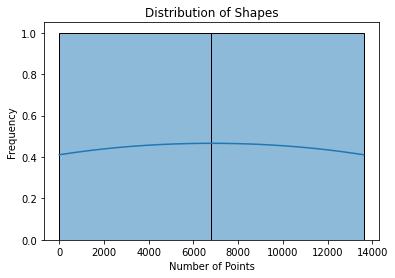

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the shapes list to a numpy array
shapes_array = np.array(shapes)[0]

# Plot the distributions of shapes
sns.histplot(data=shapes_array, bins='auto', kde=True)

# Set labels and title
plt.xlabel('Number of Points')
plt.ylabel('Frequency')
plt.title('Distribution of Shapes')

# Display the plot
plt.show()


In [5]:
origins = []
normals = []

for cp in files_to_process:
    fname = os.path.splitext(os.path.basename(cp))[0]

    if not os.path.exists(r"C:\temp\planes\{}.txt".format(fname)):
        g = 2#print(f"{fname} does not exists")
    else:
        origin, normal = get_plane(fname)
        origins.append(origin)
        normals.append(normal)


KeyboardInterrupt: 

In [56]:
len(normals)

3002

In [48]:
mean_normal = np.mean(normals, axis=0)
mean_orig = np.mean(origins, axis=0)

In [36]:
mean_normal

array([-0.34115871,  0.84640487,  0.17356184])

In [12]:
mean_orig

array([-1.9013895 , 12.77964562, -4.90804974])

In [9]:
angls = []
for normal in normals:
    ang = angle_between(mean_normal, normal)
    angls.append(ang)


In [16]:
np.degrees(np.mean(angls))

18.595733321750675

In [ ]:
.face_normals

In [63]:
faceNormals = []
for cp in files_to_process:
    fname = os.path.splitext(os.path.basename(cp))[0]
    if os.path.exists(r"C:\temp\planes\{}.txt".format(fname)):
        curNormals = get_cannal(fname).face_normals
        sampleInd = np.random.randint(curNormals.shape[0], size = 500)
        curNormals = curNormals[sampleInd]
        faceNormals.append(curNormals)

In [61]:
len(faceNormals)

3

In [64]:
X = np.stack(faceNormals)
y = np.stack(normals)

In [96]:
faceNormals.shape

AttributeError: 'list' object has no attribute 'shape'

In [70]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
# Split the data into training and testing sets
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.2, random_state=42)

# Create a RandomForestRegressor instance wrapped by a MultiOutputRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
multi_output_rf_regressor = MultiOutputRegressor(rf_regressor)

# Fit the model to the training data
multi_output_rf_regressor.fit(X_train, y_train)

# Predict target values for the testing data
y_pred = multi_output_rf_regressor.predict(X_test)
# Evaluate the performance of the model
mae = mean_absolute_error(y_test, y_pred)

In [71]:
mae

0.13538451116223207

In [66]:
y.shape

(3002, 3)

In [67]:
X.shape

(3002, 500, 3)

In [74]:
import xgboost as xgb
# 15 degdee xg boost

In [91]:
val_matrix = xgb.DMatrix(X_test, label=y_test)
data_matrix = xgb.DMatrix(X_train, label=y_train)
watchlist = [(data_matrix, 'train'), (val_matrix, 'validation')]

def angle_based_obj(preds, dtrain):
    # Get the true labels and predictions as NumPy arrays
    y_true = dtrain.get_label()
    y_pred = preds

    # Reshape y_true and y_pred to have the same shape
    y_true = y_true.reshape(-1, 3)
    y_pred = y_pred.reshape(-1, 3)

    # Normalize y_true and y_pred
    y_true_norm = np.linalg.norm(y_true, axis=1, keepdims=True)
    y_pred_norm = np.linalg.norm(y_pred, axis=1, keepdims=True)
    y_true_normalized = y_true / y_true_norm
    y_pred_normalized = y_pred / y_pred_norm

    # Calculate cosine similarity
    cos_similarity = np.sum(y_true_normalized * y_pred_normalized, axis=1)

    # Calculate gradients (partial derivatives of the cosine similarity w.r.t. y_pred)
    grad = -y_true_normalized + y_pred_normalized * cos_similarity[:, np.newaxis]

    # Calculate Hessians (second partial derivatives of the cosine similarity w.r.t. y_pred)
    # For simplicity, we use a constant Hessian (diagonal matrix) for numerical stability
    hess = np.ones_like(grad)

    # Reshape gradients and Hessians to the original shape
    grad = grad.reshape(-1)
    hess = hess.reshape(-1)

    return grad, hess

params = {
    'objective': 'reg:squarederror', # or 'reg:linear' for older versions of XGBoost
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
}

model = xgb.train(
    params,
    data_matrix,
    obj=angle_based_obj,
    num_boost_round=1000,
    evals=watchlist,
    verbose_eval=True, # or set an integer, e.g., 10, to print progress every 10 rounds
    early_stopping_rounds=50 # stops training if there's no improvement in validation RMSE for 50 rounds
)



[0]	train-rmse:0.55654	validation-rmse:0.56235
[1]	train-rmse:0.51765	validation-rmse:0.52448
[2]	train-rmse:0.48032	validation-rmse:0.48854
[3]	train-rmse:0.44476	validation-rmse:0.45383
[4]	train-rmse:0.41141	validation-rmse:0.42187
[5]	train-rmse:0.38047	validation-rmse:0.39205
[6]	train-rmse:0.35181	validation-rmse:0.36536
[7]	train-rmse:0.32576	validation-rmse:0.34157
[8]	train-rmse:0.30183	validation-rmse:0.31991
[9]	train-rmse:0.28063	validation-rmse:0.30122
[10]	train-rmse:0.26186	validation-rmse:0.28475
[11]	train-rmse:0.24493	validation-rmse:0.27033
[12]	train-rmse:0.22977	validation-rmse:0.25774
[13]	train-rmse:0.21584	validation-rmse:0.24716
[14]	train-rmse:0.20400	validation-rmse:0.23818
[15]	train-rmse:0.19391	validation-rmse:0.23041
[16]	train-rmse:0.18474	validation-rmse:0.22408
[17]	train-rmse:0.17695	validation-rmse:0.21880
[18]	train-rmse:0.16976	validation-rmse:0.21419
[19]	train-rmse:0.16400	validation-rmse:0.21054
[20]	train-rmse:0.15835	validation-rmse:0.20750
[2

In [92]:
y_val_pred = model.predict(val_matrix)
mae = mean_absolute_error(y_test, y_val_pred)


In [93]:
mae

0.17774018094152344

In [94]:
anglsp = []
for i in range(y_val_pred.shape[0]):
    ang = abs(angle_between(y_test[i], y_val_pred[i]))
    anglsp.append(ang)
np.degrees(np.mean(anglsp))

15.450799066353264

In [89]:
y_test, y_val_pred

(array([[-0.4739486 ,  0.87950295, -0.04298085],
        [-0.49621049,  0.75090951,  0.43578684],
        [-0.61952734,  0.76525116, -0.17486152],
        ...,
        [-0.33728132,  0.92647618,  0.16698286],
        [-0.48166212,  0.87163234,  0.09087716],
        [-0.17468521,  0.95221031,  0.25056064]]),
 array([[-0.35340837,  0.90979034,  0.14736252],
        [-0.4529434 ,  0.81976694,  0.15737964],
        [-0.42141643,  0.8380148 ,  0.05785855],
        ...,
        [-0.4008493 ,  0.83032745,  0.26063386],
        [-0.4999473 ,  0.8571197 ,  0.16071619],
        [-0.2610349 ,  0.7989887 ,  0.24623647]], dtype=float32))